In [1]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

# Suppress scientific notation in numpy outputs
np.set_printoptions(suppress=True)


Bad key "text.kerning_factor" on line 4 in
/Users/silver-moon/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Adjust pandas display and formatting settings
np.set_printoptions(precision = 3, linewidth = 500)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_colwidth', 500)

# Adjust plotting style to match with the notebook style
from jupyterthemes import jtplot
jtplot.style(theme='onedork', gridlines='--', grid=True, figsize=(8, 8))

# Dark theme for Jupyter Notebook
# install jupyterthemes
!pip install jupyterthemes
!jt -t onedork -cellw 98% -f roboto -T -tfs 12
#!jt -r
#!jt -t onedork -cellw 98% -f roboto -T -tfs 12
# !jt -r

In [3]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
train_path = "project_data/train.zip"

In [7]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir temp_train

mkdir: temp_train: File exists


In [8]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

In [9]:
path = "./temp_train/*/*.png"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [10]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


In [11]:
trainImg

array([[[[ 29,  47,  48],
         [ 28,  50,  41],
         [ 40,  59,  51],
         ...,
         [ 85, 102, 118],
         [ 94, 113, 129],
         [ 60,  78,  97]],

        [[ 26,  46,  43],
         [ 26,  50,  41],
         [ 31,  52,  42],
         ...,
         [ 85,  99, 115],
         [ 98, 114, 130],
         [ 61,  74,  94]],

        [[ 18,  44,  35],
         [ 30,  50,  42],
         [ 44,  63,  54],
         ...,
         [ 81,  97, 112],
         [ 77,  94, 107],
         [ 57,  74,  91]],

        ...,

        [[ 29,  50,  68],
         [ 31,  50,  68],
         [ 33,  59,  79],
         ...,
         [ 66,  87,  99],
         [ 45,  67,  84],
         [ 29,  43,  64]],

        [[ 67,  84, 104],
         [ 67,  82, 101],
         [ 74,  92, 107],
         ...,
         [ 66,  85,  99],
         [ 34,  53,  73],
         [ 35,  55,  68]],

        [[ 76,  94, 110],
         [ 66,  85, 102],
         [ 78,  97, 111],
         ...,
         [ 64,  79,  95],
        

In [12]:
trainLabel

,0
0,Cleavers
1,Cleavers
2,Cleavers
3,Cleavers
4,Cleavers
...,...
4745,Maize
4746,Maize
4747,Maize
4748,Maize


In [13]:
trainLabel[0].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: 0, dtype: int64

 Label 
 Name: Cleavers


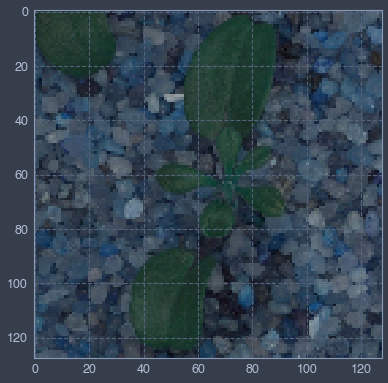

In [14]:
i = 0
image = trainImg[i]
#label = trainLabel.index[i]
print(' Label \n Name: {}'.format(trainLabel[0][i]))
plt.imshow(image);

 Label 
 Name: Sugar beet


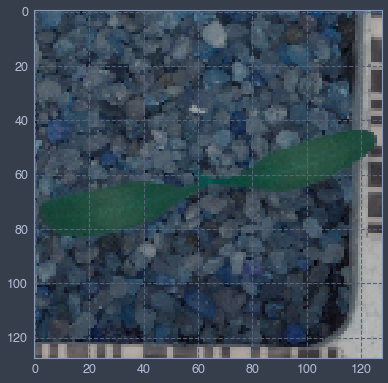

In [15]:
i = 500
image = trainImg[i]
#label = trainLabel.index[i]
print(' Label \n Name: {}'.format(trainLabel[0][i]))
plt.imshow(image);

In [47]:
len(trainImg)

4750

In [78]:
# Normalize the data
trainImg = trainImg.astype('float32') / 255.0

In [80]:
new_x = np.empty((4750, 128, 128, 3))
new_x.astype('float32')

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [81]:
len(new_x)

4750

In [82]:
new_x.shape

(4750, 128, 128, 3)

In [83]:
for idx, line in enumerate(trainImg):
    new_x[idx] = line

In [86]:
# Now we apply the gaussian blur to each 28x28 pixels array (image) to reduce the noise in the image
for idx, line in enumerate(trainImg):
    new_x[idx] = cv2.GaussianBlur(line, (5, 5), 0)

In [87]:
new_x[0].shape

(128, 128, 3)

 Label 
 Name: Cleavers


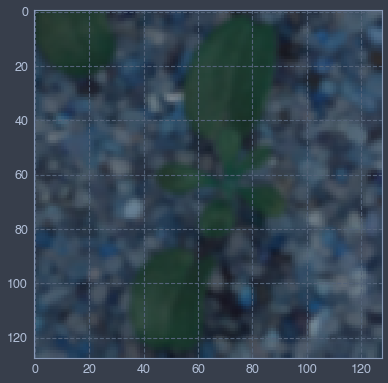

In [88]:
i = 0
image = new_x[i]
#label = trainLabel.index[i]
print(' Label \n Name: {}'.format(trainLabel[0][i]))
#plt.imshow((image * 255).astype(np.uint8));
plt.imshow(image);

 Label 
 Name: Cleavers


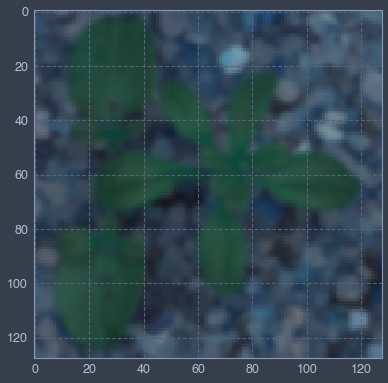

In [89]:
i = 50
image = new_x[i]
#label = trainLabel.index[i]
print(' Label \n Name: {}'.format(trainLabel[0][i]))
plt.imshow(image);

In [91]:
#trainLabel_oh = keras.utils.to_categorical(trainLabel, 12)
trainLabel_oh = pd.get_dummies(trainLabel)

In [93]:
trainLabel_oh.shape

(4750, 12)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(new_x, trainLabel_oh, train_size=0.7, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [96]:
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('X_valid Shape:', X_valid.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (3325, 128, 128, 3)
X_test Shape: (713, 128, 128, 3)
X_valid Shape: (712, 128, 128, 3)
y_train Shape: (3325, 12)
y_test Shape: (713, 12)
y_valid Shape: (712, 12)


In [99]:
%%time
# Clear the session and set a random seed
tf.keras.backend.clear_session()
tf.random.set_seed(1)

# Initiate the model and add layers
nn_1 = tf.keras.models.Sequential([Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (128, 128, 3)),
                                   Conv2D(32, (3,3), activation='relu'),
                                   MaxPooling2D(2, 2),
                                   Dropout(0.25),
                                   Conv2D(64, (3,3), padding='same', activation='relu'),
                                   Conv2D(64, (3,3), activation='relu'),
                                   MaxPooling2D(2, 2),
                                   Dropout(0.25),
                                   Flatten(),
                                   Dense(512, activation = 'relu'), 
                                   Dropout(0.5),
                                   Dense(12, activation = 'softmax')]) 

# Add loss function, optimizer and evaluation metric to the model
nn_1.compile(loss = 'categorical_crossentropy', 
             optimizer = 'Adam', 
             metrics = ['accuracy']) 

# Add constraints and record best weights to resume 
callbacks = [
    EarlyStopping(
        monitor='val_loss',             # Monitor validation loss history
        min_delta=0.001,                # Stop training when validation loss is no longer improving by at least 0.001
        patience=10,                    # Look at validation loss improvement over the last 10 epochs
        verbose=1) 
    
    #ModelCheckpoint('./nn1/best_weights_nn1.h5',
    #   monitor='val_loss',
    #   verbose=1,
    #   save_best_only=True,
    #   save_weights_only=True,
    #   mode='auto')
]

print(nn_1.summary())

# Train the model
nn_1.fit(X_train, y_train, validation_data = (X_valid, y_valid), callbacks=callbacks, epochs = 15, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [102]:
!mkdir nn1
nn_1.save('./nn1/nn_1_model.h5')
nn_1.save_weights('./nn1/nn_1_weights.h5')

In [103]:
nn_1_trained = load_model('./nn1/nn_1_model.h5')
nn_1_trained.load_weights('./nn1/nn_1_weights.h5')

In [104]:
scores = nn_1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

713/713 [==============================] - 4s 6ms/sample - loss: 1.2778 - accuracy: 0.7153
Test loss: 1.2777633669447848
Test accuracy: 0.7152875


In [115]:
# Display an image from a test set
#samples = [2, 3, 33, 36, 59]
def output_func(i):
    test_image = X_test[i]
    plt.imshow(test_image);
    predictions = nn_1_trained.predict(np.expand_dims(test_image, axis = 0))
    print(predictions)
    print('\n Predicted class: %.0f' % np.argmax(predictions))

[[0.    0.    0.    0.995 0.    0.    0.    0.001 0.004 0.    0.    0.   ]]

 Predicted class: 3


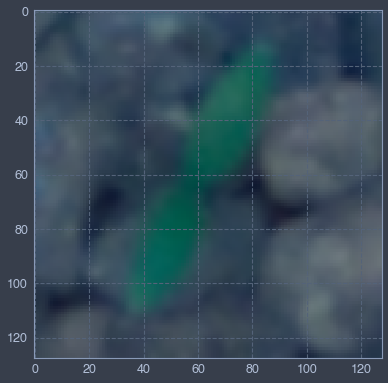

In [116]:
output_func(2)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 Predicted class: 1


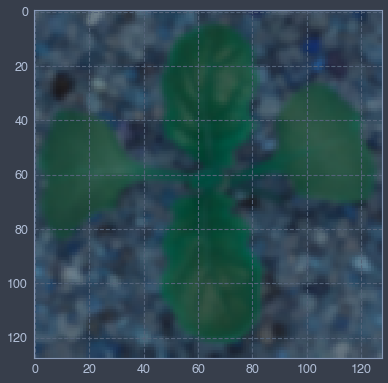

In [117]:
output_func(3)

[[0.031 0.    0.001 0.024 0.084 0.768 0.03  0.001 0.003 0.    0.    0.058]]

 Predicted class: 5


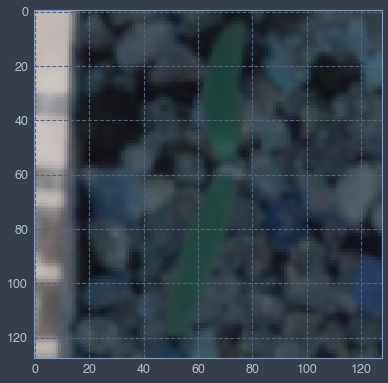

In [118]:
output_func(33)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

 Predicted class: 10


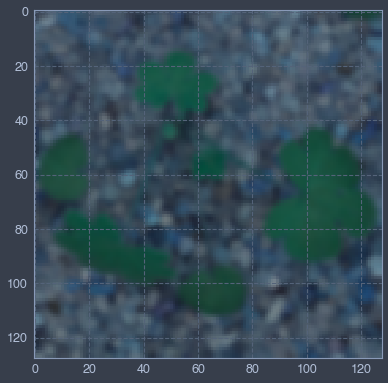

In [119]:
output_func(36)

[[0.    0.    0.    0.    0.    0.998 0.    0.    0.    0.    0.002 0.   ]]

 Predicted class: 5


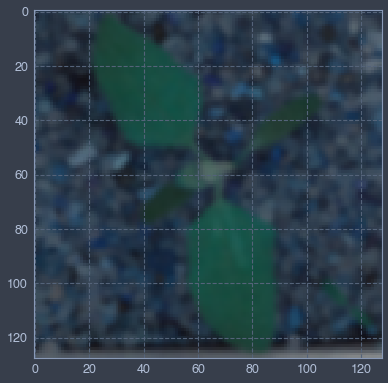

In [120]:
output_func(59)

In [125]:
y_pred = nn_1_trained.predict(X_test)

In [126]:
y_pred[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [127]:
# Select a class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

# Predicted class for the first observation
y_pred_class[0]

1

In [128]:
y_pred_class

array([ 1, 11,  3,  1,  6,  1,  6,  6,  6,  6,  7,  8,  2,  3, 10,  4,  2,  5,  0,  7,  4,  7,  6,  5,  5, 11, 11,  1,  5,  0,  1,  5, 10,  5, 11,  7, 10, 10,  8,  7,  3,  2,  2,  2, 10,  1,  9,  8,  0,  8,  1,  6,  1,  9,  6,  1,  8, 10,  0,  5,  8,  5,  6,  5,  6,  1,  3,  2,  0, 11,  5, 10, 10,  8,  2,  6,  2,  9,  0,  6, 10,  3,  3,  6,  3,  4,  1,  1,  3,  1,  5,  5,  1, 11,  3,  0, 10,  5,  0,  8,  5, 10,  6,  6, 10,  5, 10, 11, 10,  0,  6, 10,  6,  3,  4,  7,  0,  5,  2,  3,  0,  1,  3,
       10,  2, 11,  9, 11,  4,  8, 10,  3,  1,  1, 11, 10,  0,  7,  0,  7, 10, 10,  6, 10, 11,  3,  5,  2,  7, 11, 10, 11,  5,  5,  0, 10,  8,  1,  6,  1,  1,  1, 10,  2,  3,  0, 10, 11,  1,  1, 11,  0, 11,  5,  2,  5, 10,  8,  8,  1,  8,  5,  5,  0,  3,  0,  1,  8,  1,  3,  3,  7,  8,  8,  1,  1, 11, 10,  3, 10, 11,  1, 10, 10, 11,  8,  6, 10, 10, 10, 11,  5,  3,  3,  5,  3,  0,  6,  6,  4,  2,  7,  7, 11,  6,  5, 10,  8,  8,  5,  1,  5, 11,  5,  5,  5,  5,  5,  1,  6, 11,  8,  3, 10, 10,  0,
  

In [146]:
y_pred_class.shape

(713,)

In [147]:
y_test.shape

(713, 12)

In [148]:
y_test.head()

,0_Black-grass,0_Charlock,0_Cleavers,0_Common Chickweed,0_Common wheat,0_Fat Hen,0_Loose Silky-bent,0_Maize,0_Scentless Mayweed,0_Shepherds Purse,0_Small-flowered Cranesbill,0_Sugar beet
4161,0,1,0,0,0,0,0,0,0,0,0,0
559,0,0,0,0,0,0,0,0,0,0,0,1
1141,0,0,0,1,0,0,0,0,0,0,0,0
4159,0,1,0,0,0,0,0,0,0,0,0,0
3628,1,0,0,0,0,0,0,0,0,0,0,0


In [144]:
y_test_class = np.argmax(y_test, axis = 0)

ValueError: Shape of passed values is (12, 1), indices imply (713, 12)

In [145]:
# Create a confusion matrix
cm = pd.crosstab(test_set.classes, y_pred_class, rownames = ['Actual'], colnames = ['Prediction'])
cm

AttributeError: 'NumpyArrayIterator' object has no attribute 'classes'